In [9]:
import matplotlib.pyplot as plt
import numpy as np
import random
import tensorflow as tf
from cooltools.lib.numutils import set_diag
from Bio import SeqIO

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from models import advanced_2d_cnn

In [7]:
# should be version 1.x
print(tf.__version__)

1.15.2


In [2]:
# the following directive activates inline plotting
%matplotlib inline

# allow to allocate resources for model training
config = tf.ConfigProto(log_device_placement=True)
config.gpu_options.allow_growth = True

In [3]:
from tensorflow.keras.backend import set_session
sess = tf.Session(config=config)
set_session(sess)

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device



In [4]:
# UTIL FUNCTIONS

def plot_hic(matrix, use_log_scale = False, chromosome_position = ()):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    
    if use_log_scale:
        im = ax.matshow(np.log10(matrix), cmap='YlOrRd')
        fig.colorbar(im)
    else:
        im = ax.matshow(matrix, cmap='YlOrRd')
        fig.colorbar(im)
    
    if len(chromosome_position) != 0:
        ax.set_title(f"{chromosome_position[0]}: {chromosome_position[1][0]}-{chromosome_position[1][1]}", fontsize=25)

        
def from_upper_triu(vector_repr, matrix_len = 512, num_diags = 2):
    z = np.zeros((matrix_len,matrix_len))
    triu_tup = np.triu_indices(matrix_len,num_diags)
    z[triu_tup] = vector_repr[0, :, 0]
    
    for i in range(-num_diags+1,num_diags):
        set_diag(z, np.nan, i)
        
    return z + z.T


def one_hot_dna(sequence):
    seq_array = np.array(list(sequence))

    label_encoder = LabelEncoder()
    integer_encoded_seq = label_encoder.fit_transform(seq_array)

    integer_encoded_seq = integer_encoded_seq.reshape(len(integer_encoded_seq), 1)

    onehot_encoder = OneHotEncoder(sparse = False)
    result = onehot_encoder.fit_transform(integer_encoded_seq)

    # if Ns are present in the DNA sequence, result will have 5 columns. We delete 4th column which has Ns
    # N row in the resulting training set will have all 0s
    if result.shape[1] == 5:
        result = np.delete(result, 3, 1)

    return result

In [23]:
######################### 
# Advanced 2D CNN Model
#########################

advanced_model = advanced_2d_cnn.Model().get_model()

# Load best weights from augmented training
advanced_model.load_weights("./weights/v2/model_80_epochs.h5")

In [20]:
# Read DNA sequence from a fasta file
# Sequence should be 526.000 nucleotides long

FASTA_FILENAME = 'dna_seq_example'
dna_seq = str(list(SeqIO.parse(open(f"./{FASTA_FILENAME}.fa"),'fasta'))[0].seq).upper()

# one hot encode
dna_seq_one_hot = one_hot_dna(dna_seq)

# crop and prepare dna for the model
dna_seq_one_hot = dna_seq_one_hot[856:(526000 - 856), :].reshape(1, 524288, 4)

dna_seq_one_hot.shape

(1, 524288, 4)

In [24]:
# Predict
prediction = advanced_model.predict(dna_seq_one_hot)

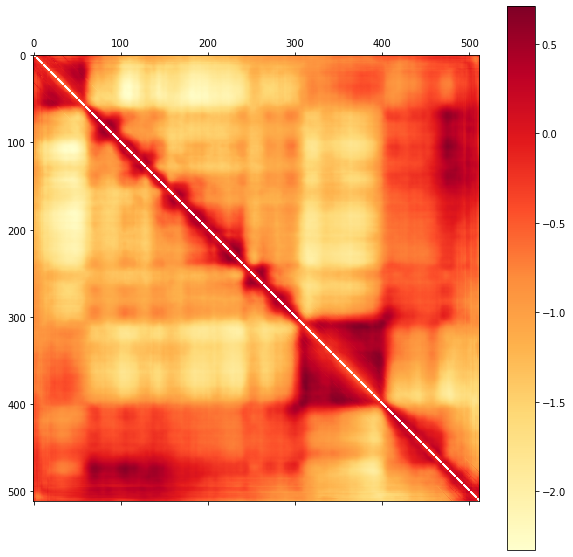

In [25]:
# Plot Hi-C
plot_hic(from_upper_triu(prediction))